# Day 7 - Supervised Learning Challenge

Let’s take what you’ve learned over the past week and put it into practice. The dataset we will be using contains two csv files ‘data’ and ‘target’.

Each row in the ‘data’ belongs to a ‘measurement’ and each column represents a ‘feature’. For each row in the ‘data’ you have a corresponding class label in ‘target’. You can consider the row-numbers as keys.

Complete the following:

Explore your data. 
- Can you identify anything interest that is worth noting from the data?
- Define a set of possible classifiers and show which one performs best. Keep in mind the problem of overfitting.
- Using feature selection try to reduce the number of features. In the dataset you have over 100 features. Find the good ones for your classifier.

Keep in mind that there is no best solution to the challenge. Show how you approach a problem, and the skills/methods you use in that approach.



In [30]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from typing import Dict, Tuple, Callable
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RandomizedSearchCV

In [6]:
data = pd.read_csv('features_train.csv')

In [7]:
target = pd.read_csv('target_train.csv')

In [8]:
finaltest = pd.read_csv('features_test.csv')

Join training data with training target

In [9]:
data2 = pd.concat([data, target], axis=1)

But now we have 2 id columns, so we will remove these

In [10]:
data2 = data2.drop(columns=['Id'])

Splitting our training data into X = features and y = label

In [11]:
X = data2.loc[:, data2.columns != 'Expected']
y = data2['Expected'].values

### Use Variance Inflation Factor (VIF) to search for colinearity

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [13]:
calculate_vif_(X)

Remaining variables:
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '110', '111', '112', '113', '114', '115', '116', '117', '118', '119'],
      dtype='object', length=120)


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,2.311705,0.445665,7.020637,1.582505,3.010977,1.375501,29.897623,2.886738,-8.641869,0.414074,...,0.642797,0.706869,0.997519,1.270321,0.109460,2.829606,-8.292344,1.423754,0.090224,2.006436
1,0.580430,0.200428,22.176950,0.479475,0.173418,0.106690,-28.162402,5.388960,-9.188298,1.203232,...,1.966491,0.330869,0.449754,0.257662,-1.131653,-0.908362,20.468617,1.146844,0.142068,0.373541
2,0.042687,0.641976,1.663984,0.998398,1.262488,0.784453,-22.016388,1.512673,-3.526049,0.176904,...,0.897811,0.610529,0.158270,5.695307,0.358590,-8.164399,0.596139,0.522287,0.832107,4.264087
3,0.060388,1.408700,92.827212,2.691115,0.645211,0.710104,12.132919,1.606096,-0.782570,3.147786,...,1.375550,0.708163,0.537862,1.357389,-1.659754,-1.105801,-6.426477,0.404628,0.452828,1.106436
4,1.045148,0.704313,4.823582,0.546102,0.397827,0.606078,-11.135888,0.639788,-9.182691,0.841208,...,10.556016,0.225400,0.672425,0.257381,-0.435355,7.744958,10.908781,4.413541,0.782079,0.279165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.039133,1.932955,30.527258,1.895394,1.460542,0.192537,32.700597,0.492404,-12.989238,2.891657,...,0.074315,0.813626,0.591380,0.450031,2.068493,1.602963,0.167108,0.134495,0.892673,3.217339
9996,0.000060,0.161456,0.645531,1.651073,3.671002,0.051387,-19.142738,0.733723,-15.606911,0.315542,...,0.192683,0.792759,0.091530,1.726438,1.238569,-2.790124,-0.720931,0.639697,0.272982,1.503869
9997,4.348522,0.496327,2.274211,0.872857,0.306053,0.546092,26.789277,2.595019,-7.808649,1.892135,...,1.143706,0.060087,0.700386,0.611112,-0.732795,-6.374433,0.548602,4.716338,0.422413,1.251670
9998,0.009933,0.571243,1.990313,0.647652,0.559522,0.363403,6.723800,1.081141,11.456673,0.344549,...,0.435313,0.440300,0.386854,0.859887,-1.179432,8.891759,12.228795,1.913393,0.153819,0.385354


Results from VIF search shows no colinearity with a VIF threshold of 5. So we keep all the features so far.
Let's look at the data histogram.

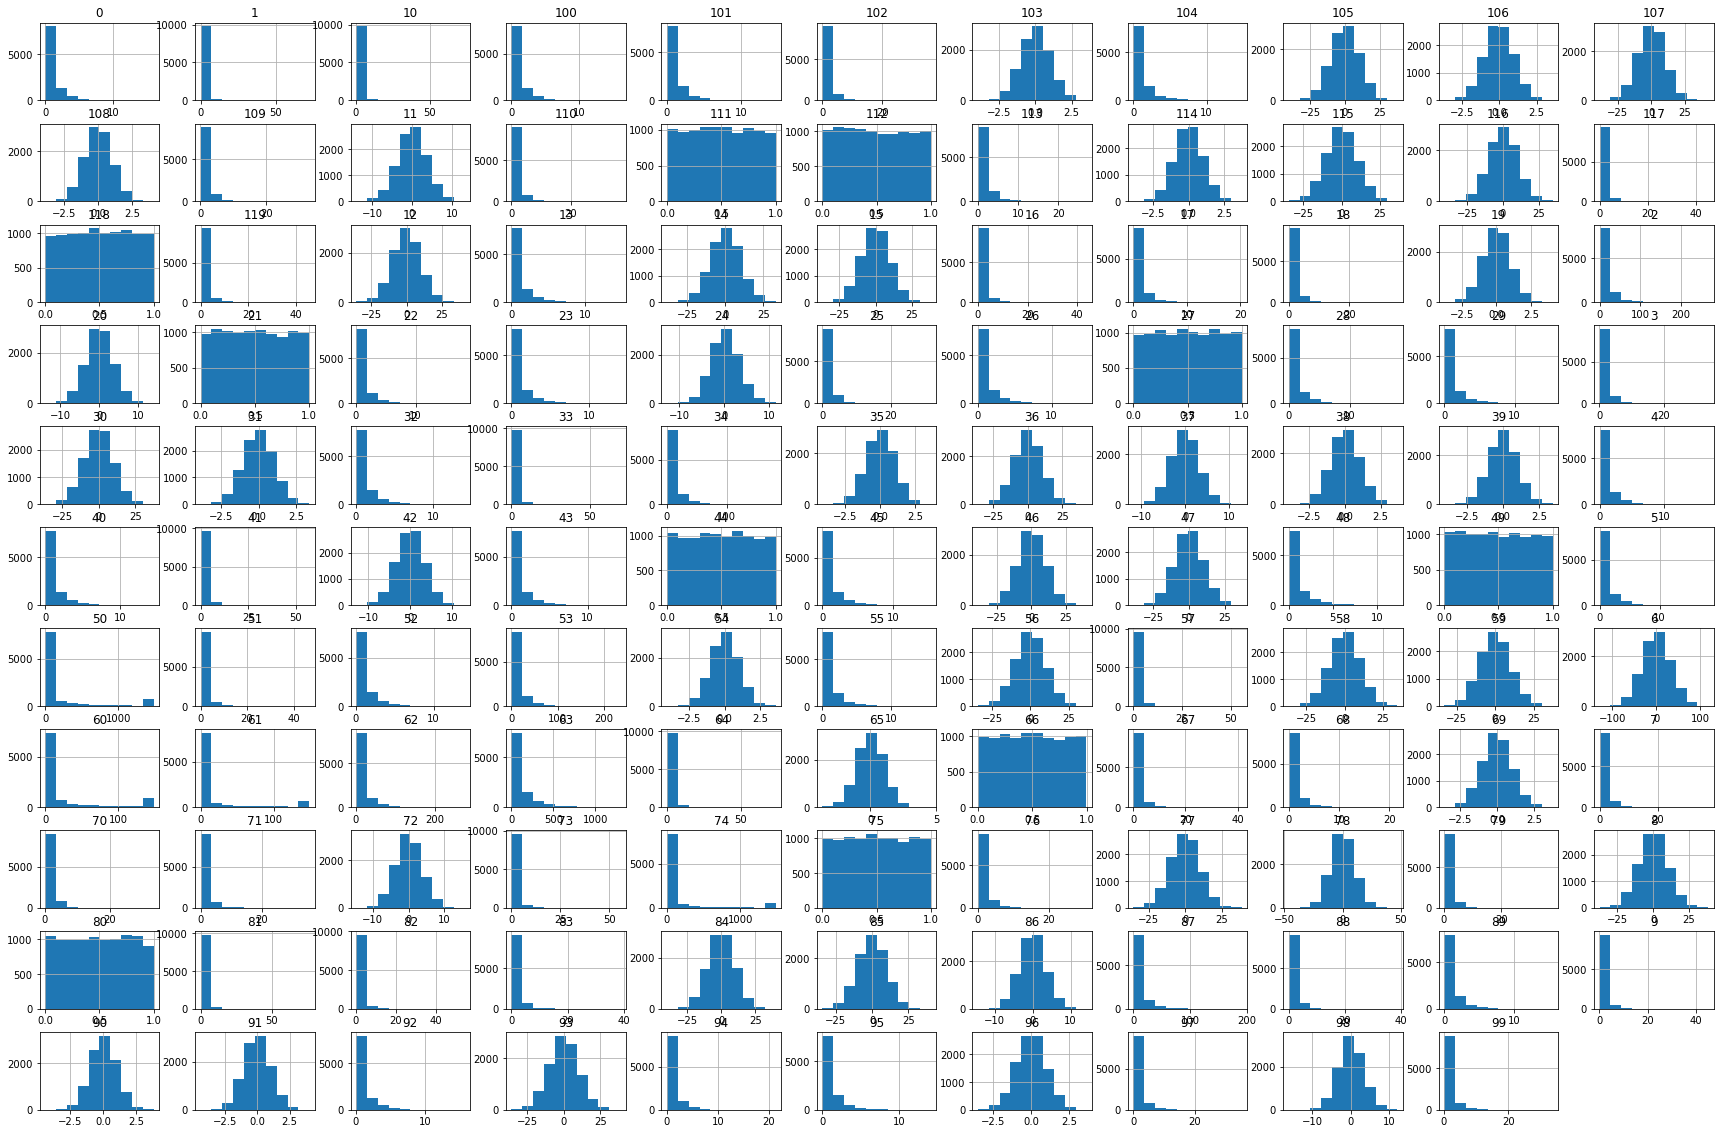

In [14]:
X.hist(figsize = (30,20));

A lot of the data has very similar distributions. The right skewed data that has a very large spike on the far left looks like it could be made more normal by taking the logarithm of it.

In [48]:
# Transform the skewed numeric features by taking log.
# This will make the features more normal.

from scipy.stats import skew
loggedX = X

skewed = loggedX.apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
#transform/apply the (log)
loggedX[skewed] = np.log10(loggedX[skewed])


array([0, 0, 2, ..., 2, 2, 1])

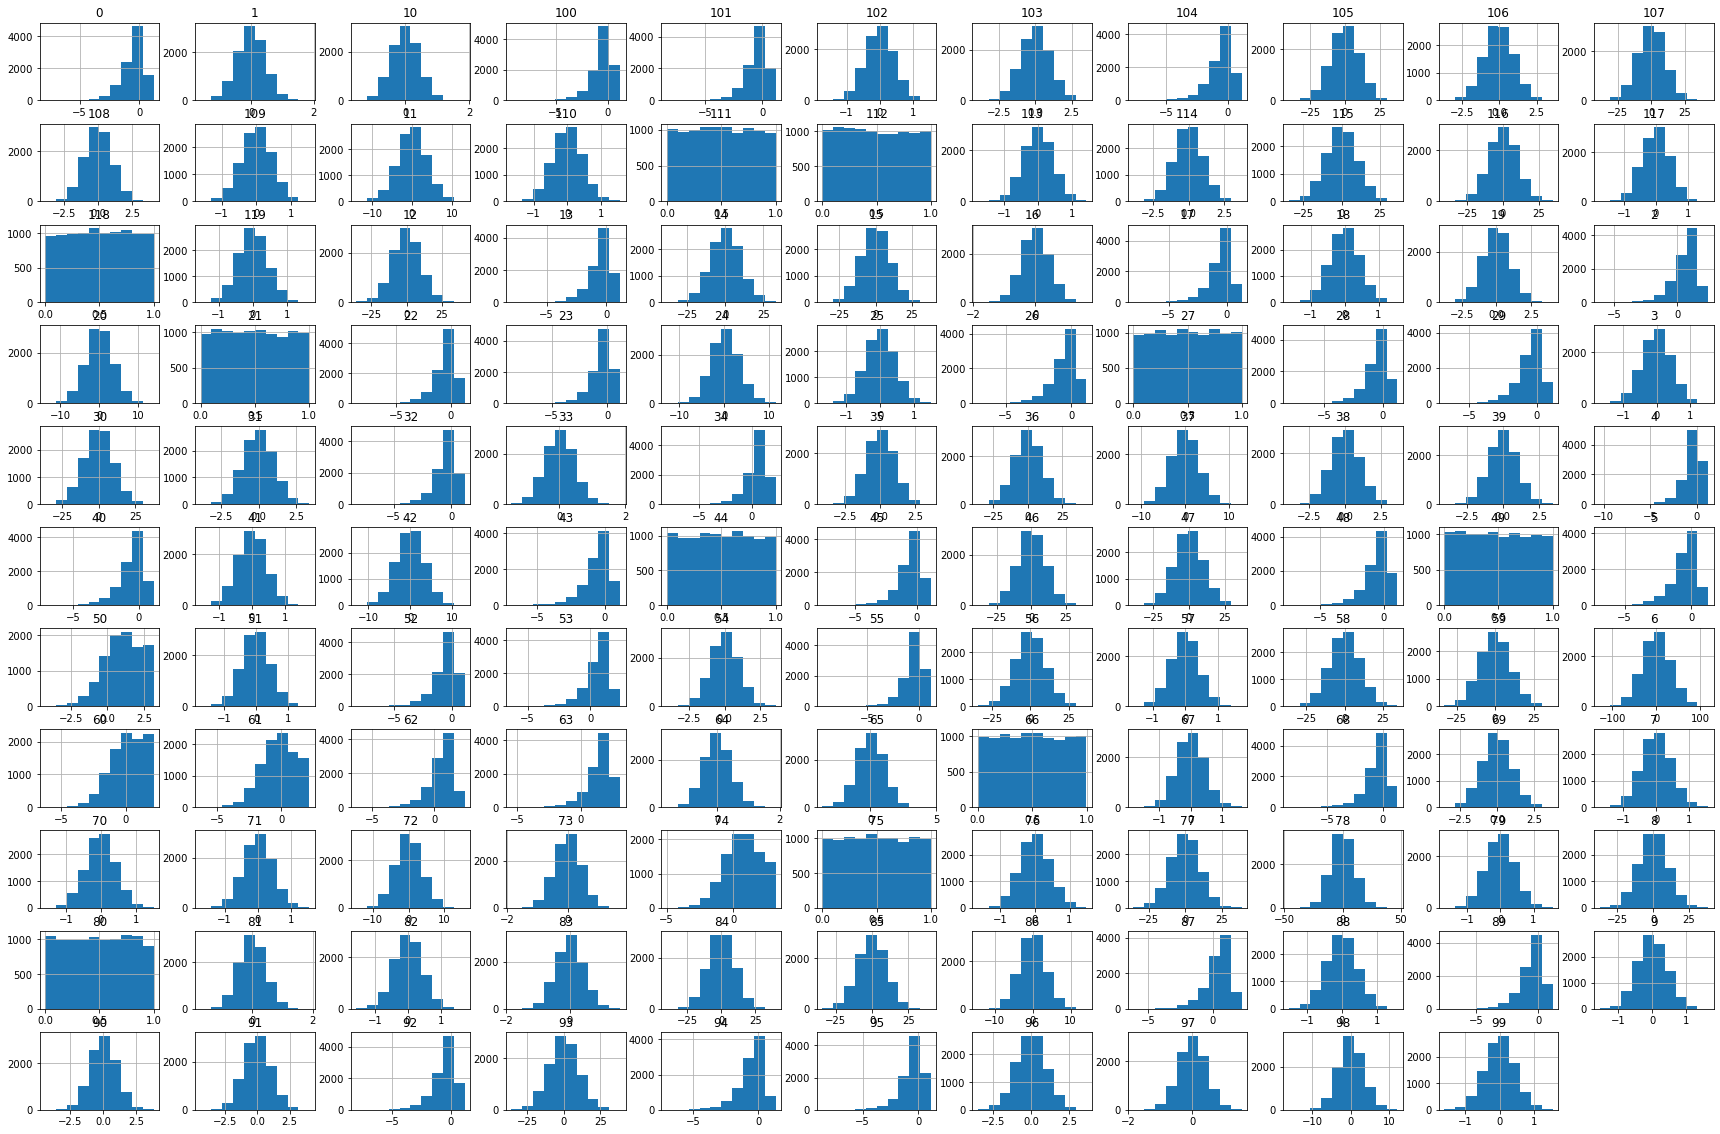

In [16]:
loggedX.hist(figsize = (30,20));

We can see that applying log base 10 helped alot; the data that we applied the log to (based on skew threshold of 0.75) is still skewed, but is much closer to being normally distributed now. The log changed it from being very right skewed to slightly left skewed.
Since out y label data has discrete values of 0,1,2 this looks like a classification problem. 

Let's progress with a simple random forrest, and to probe the weights of variables since removing features based on VIF wasn't possible earlier.

In [52]:
#normally we would split the data into 80% train and 20% test but the data is already split for us so we will train
# on the entire train data we have.



rf = RandomForestClassifier()
#pipeline to include feature selection and model selection
pipeline = Pipeline([('kbest',SelectKBest()),('classifier', rf)])


param_grid = {
    "classifier__n_estimators": [50],
    "classifier__max_depth":[10],
    "classifier__min_samples_split":[5],
    "classifier__min_samples_leaf":[1],
    "classifier__criterion":['gini'],
    "kbest__k":[120]}


rf_rg_pipe = RandomizedSearchCV(pipeline, 
                                param_grid, 
                                cv=None, 
                                scoring='f1_macro',
                                n_iter=50,verbose=2,
                                n_jobs=-1)

rf_rg_pipe.fit(loggedX,y)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/timothypillow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('kbest',
                                              SelectKBest(k=10,
                                                          score_func=<function f_classif at 0x119009b70>)),
                                             ('classifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
        

In [53]:
rf_rg_pipe.best_score_

0.5242149907391492

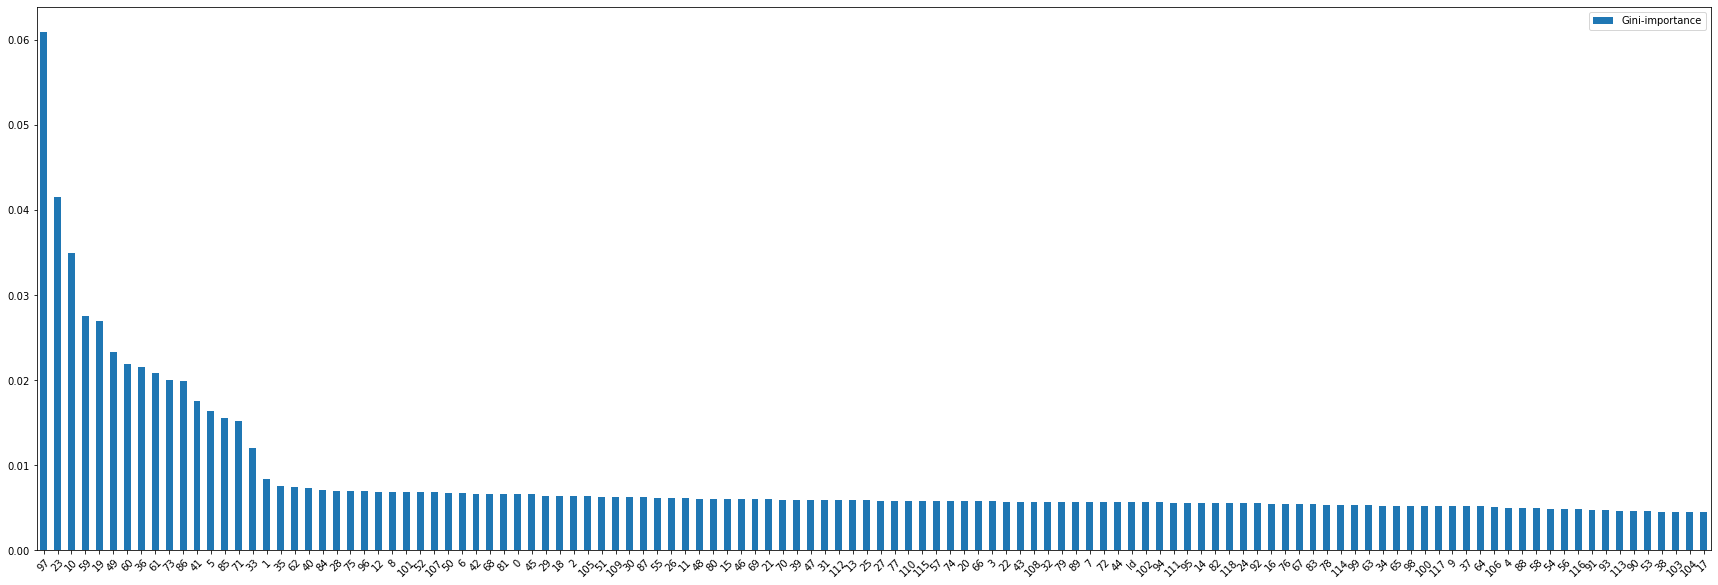

In [54]:
import pandas as pd
%matplotlib inline
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, rf_rg_pipe.best_estimator_.named_steps['classifier'].feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending = False).plot(kind='bar', rot=45,figsize=(30,10))

In [55]:
newX = loggedX[['97', '10', '23','19','59','49','60','36','5','61','86','41','71','73','85','33','62']].copy()

In [56]:
newX.head()

,97,10,23,19,59,49,60,36,5,61,86,41,71,73,85,33,62
0,-0.112827,0.300490,-1.115912,0.510913,-0.419137,0.560206,1.723488,-2.184300,0.138461,-0.330055,-0.315395,0.630124,-0.283474,0.031533,16.767320,0.116368,1.212349
1,-0.029326,0.662603,0.576964,-1.377308,4.851981,0.617854,-0.986423,-12.565164,-0.971876,-2.093394,-1.230639,0.292078,0.409220,0.199262,-5.961822,0.685517,0.667162
2,-0.607530,0.136273,-2.887198,-0.132633,6.204435,0.520316,0.092866,6.481368,-0.105433,-0.468905,6.344787,0.142087,0.453020,0.236598,-7.022517,-0.052289,1.976098
3,-0.058644,0.912001,-0.485205,0.296963,2.381283,0.597341,1.633149,7.610446,-0.148678,0.199155,-2.016885,0.003105,-0.941606,-0.674884,-1.731318,0.155613,1.165023
4,-0.610589,0.429219,-0.304758,-0.585741,22.940537,0.590310,-1.645713,-2.797768,-0.217472,-0.398148,3.523166,0.595613,-0.058994,0.729165,4.286830,-0.272721,0.908120


In [57]:
rf = RandomForestClassifier()
#pipeline to include feature selection and model selection
pipeline = Pipeline([('kbest',SelectKBest()),('classifier', rf)])


param_grid = {
    "classifier__n_estimators": [5,10,20],
    "classifier__max_depth":[10],
    "classifier__min_samples_split":[1,2,3,4,5],
    "classifier__min_samples_leaf":[1,2,3],
    "classifier__criterion":['gini'],
    "kbest__k":[3,5,10]}


rf_rg_pipe = RandomizedSearchCV(pipeline, 
                                param_grid, 
                                cv=None, 
                                scoring='f1_macro',
                                n_iter=50,verbose=2,
                                n_jobs=-1)

rf_rg_pipe.fit(newX,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   23.8s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('kbest',
                                              SelectKBest(k=10,
                                                          score_func=<function f_classif at 0x119009b70>)),
                                             ('classifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
        

In [59]:
rf_rg_pipe.best_score_

0.394899113473705

In [61]:
rf = RandomForestClassifier()
#pipeline to include feature selection and model selection
pipeline = Pipeline([('kbest',SelectKBest()),('classifier', rf)])


param_grid = {
    "classifier__n_estimators": [50],
    "classifier__max_depth":[10],
    "classifier__min_samples_split":[5],
    "classifier__min_samples_leaf":[1],
    "classifier__criterion":['gini'],
    "kbest__k":[120]}


rf_rg_pipe = RandomizedSearchCV(pipeline, 
                                param_grid, 
                                cv=None, 
                                scoring='f1_macro',
                                n_iter=50,verbose=2,
                                n_jobs=-1)

rf_rg_pipe.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/timothypillow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('kbest',
                                              SelectKBest(k=10,
                                                          score_func=<function f_classif at 0x119009b70>)),
                                             ('classifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
        

In [62]:
rf_rg_pipe.best_score_

0.532016278415906

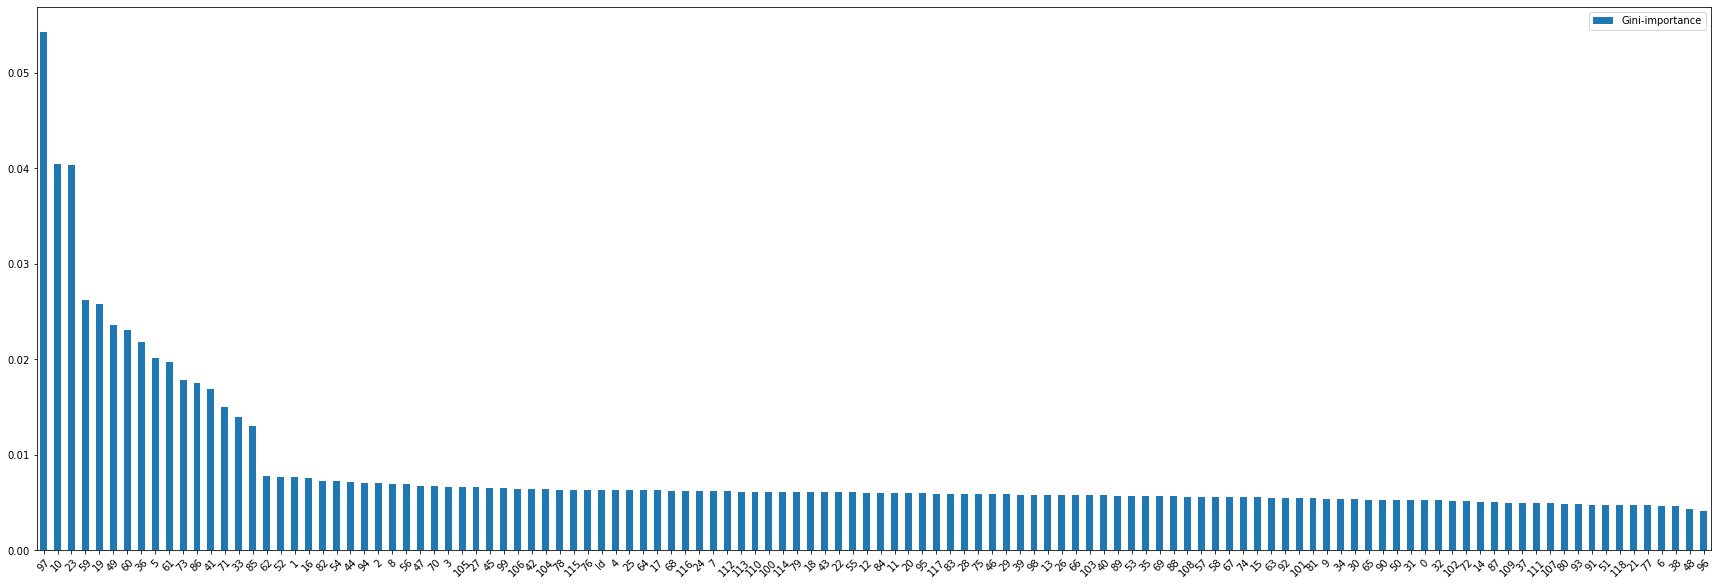

In [63]:
import pandas as pd
%matplotlib inline
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, rf_rg_pipe.best_estimator_.named_steps['classifier'].feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending = False).plot(kind='bar', rot=45,figsize=(30,10))

In [64]:
newX = X[['97', '10', '23','19','59','49','60','36','5','61','86','41','71','73','85','33','62']].copy()

In [65]:
rf = RandomForestClassifier()
#pipeline to include feature selection and model selection
pipeline = Pipeline([('kbest',SelectKBest()),('classifier', rf)])


param_grid = {
    "classifier__n_estimators": [50],
    "classifier__max_depth":[1,3,6,8,12],
    "classifier__min_samples_split":[1,2,3,4],
    "classifier__min_samples_leaf":[1],
    "classifier__criterion":['gini'],
    "kbest__k":[5,10,15]}


rf_rg_pipe = RandomizedSearchCV(pipeline, 
                                param_grid, 
                                cv=None, 
                                scoring='f1_macro',
                                n_iter=50,verbose=2,
                                n_jobs=-1)

rf_rg_pipe.fit(newX,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('kbest',
                                              SelectKBest(k=10,
                                                          score_func=<function f_classif at 0x119009b70>)),
                                             ('classifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
        

In [66]:
rf_rg_pipe.best_score_

0.3953330441676976

In [13]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
#pipeline to include feature selection and model selection
pipeline = Pipeline([('kbest',SelectKBest()),('classifier', xgb)])


param_grid = {
    'kbest__k':[120,17],
    "classifier__n_estimators": [3,5,7],
    "classifier__base_estimator":[None],
    "classifier__learning_rate":[0.1],
    "classifier__algorithm":['SAMME']}


xgb_rcv = RandomizedSearchCV(pipeline, 
                                param_grid, 
                                cv=5, 
                                scoring='f1_macro',
                                n_iter=50,verbose=2,
                                n_jobs=-1)

xgb_rcv.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/timothypillow/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('kbest',
                                              SelectKBest(k=10,
                                                          score_func=<function f_classif at 0x11622fb70>)),
                                             ('classifier',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            gamma=0,
                                                            learning_rate=0.1,
                                                            max_delta_step=0,

In [15]:
xgb_rcv.best_score_

0.49786920373871124

In [17]:
xgb_rcv.best_estimator_

Pipeline(memory=None,
         steps=[('kbest',
                 SelectKBest(k=120,
                             score_func=<function f_classif at 0x11622fb70>)),
                ('classifier',
                 XGBClassifier(algorithm='SAMME', base_estimator=None,
                               base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None, n_estimators=7,
                               n_jobs=1, nthread=None,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [80]:
#newX = X[['97', '10', '23','49','59','19','60','5','36','73','86','61','33','41','85','71','62','1','66','52','6','64','83','51','89','76','72']].copy()

In [21]:
xgb = XGBClassifier(
max_depth=3,
    learning_rate=0.1,
    n_estimators=50,
    verbosity=1,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

In [22]:
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [27]:
xgb.feature_importances_

array([0.01809023, 0.01377504, 0.01191078, 0.0111869 , 0.01348241,
       0.        , 0.03782673, 0.        , 0.01485103, 0.        ,
       0.        , 0.05140094, 0.02154796, 0.01652787, 0.        ,
       0.00552698, 0.00705383, 0.        , 0.00691642, 0.        ,
       0.03276437, 0.        , 0.        , 0.        , 0.03982376,
       0.        , 0.        , 0.01025001, 0.        , 0.        ,
       0.00955649, 0.        , 0.        , 0.        , 0.02731126,
       0.        , 0.        , 0.02968852, 0.        , 0.01553704,
       0.        , 0.        , 0.0249379 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04434726, 0.        , 0.01064705, 0.01645701, 0.00994248,
       0.        , 0.        , 0.        , 0.01691868, 0.        ,
       0.03206404, 0.03450199, 0.03079039, 0.01835755, 0.01030947,
       0.01547382, 0.        , 0.01725136, 0.        , 0.        ,
       0.        , 0.00916912, 0.02152269, 0.        , 0.03157

In [29]:
important_features_dict = {}
for x,i in enumerate(xgb.feature_importances_):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print('Most important features: %s' %important_features_list)

Most important features: [98, 11, 50, 24, 6, 61, 20, 87, 60, 74, 62, 37, 34, 42, 12, 72, 86, 63, 0, 67, 58, 13, 53, 95, 39, 65, 8, 1, 4, 117, 2, 107, 3, 90, 52, 64, 27, 54, 106, 114, 84, 30, 71, 78, 79, 77, 108, 104, 94, 16, 18, 100, 82, 15, 99, 5, 7, 9, 10, 14, 17, 19, 21, 22, 23, 25, 26, 28, 29, 31, 32, 33, 35, 36, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 55, 56, 57, 59, 66, 68, 69, 70, 73, 75, 76, 80, 81, 83, 85, 88, 89, 91, 92, 93, 96, 97, 101, 102, 103, 105, 109, 110, 111, 112, 113, 115, 116, 118, 119]
